# Using Paint-with-words with Textual Inversion

This simple notebook will show you how to use paint-with-words with textual inversion, using example embeddings from sd-concepts-library.

To learn more about sd-concepts-library, please visit [sd-concepts-library](https://huggingface.co/sd-concepts-library). There is more info about training textual inversion in the link as well.


In [ ]:
from paint_with_words import pww_load_tools

loaded = pww_load_tools("cuda:0", hf_model_path="CompVis/stable-diffusion-v1-4")

In [4]:
import torch

vae, unet, text_encoder, tokenizer, scheduler = loaded

def load_learned_embed_in_clip(
    learned_embeds_path, text_encoder, tokenizer, token=None
):
    loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

    # separate token and the embeds
    trained_token = list(loaded_learned_embeds.keys())[0]
    embeds = loaded_learned_embeds[trained_token]

    # cast to dtype of text_encoder
    dtype = text_encoder.get_input_embeddings().weight.dtype

    # add the token in tokenizer
    token = token if token is not None else trained_token
    num_added_tokens = tokenizer.add_tokens(token)
    i = 1
    while num_added_tokens == 0:
        print(f"The tokenizer already contains the token {token}.")
        token = f"{token[:-1]}-{i}>"
        print(f"Attempting to add the token {token}.")
        num_added_tokens = tokenizer.add_tokens(token)
        i += 1

    # resize the token embeddings
    text_encoder.resize_token_embeddings(len(tokenizer))

    # get the id for the token and assign the embeds
    token_id = tokenizer.convert_tokens_to_ids(token)
    text_encoder.get_input_embeddings().weight.data[token_id] = embeds
    return token


In [5]:
import os
import wget
import requests

model_id = "sd-concepts-library/midjourney-style"


# CODE FROM https://huggingface.co/spaces/sd-concepts-library/stable-diffusion-conceptualizer/blob/main/app.py.
# MIT Licensed

embeds_url = f"https://huggingface.co/{model_id}/resolve/main/learned_embeds.bin"
os.makedirs(model_id,exist_ok = True)
if not os.path.exists(f"{model_id}/learned_embeds.bin"):
    try:
        wget.download(embeds_url, out=model_id)
    except:
        print("Download failed. Trying with requests.")

token_identifier = f"https://huggingface.co/{model_id}/raw/main/token_identifier.txt"
response = requests.get(token_identifier)
token_name = response.text

concept_type = f"https://huggingface.co/{model_id}/raw/main/type_of_concept.txt"
response = requests.get(concept_type)
concept_name = response.text


In [6]:
tok = load_learned_embed_in_clip(
    f"{model_id}/learned_embeds.bin", text_encoder, tokenizer, token=None
)
tok

'<midjourney-style>'

Warning ratio 8 : token [-1] not found in text
Warning ratio 16 : token [-1] not found in text
Warning ratio 32 : token [-1] not found in text
Warning ratio 64 : token [-1] not found in text


100%|██████████| 30/30 [00:03<00:00,  7.70it/s]


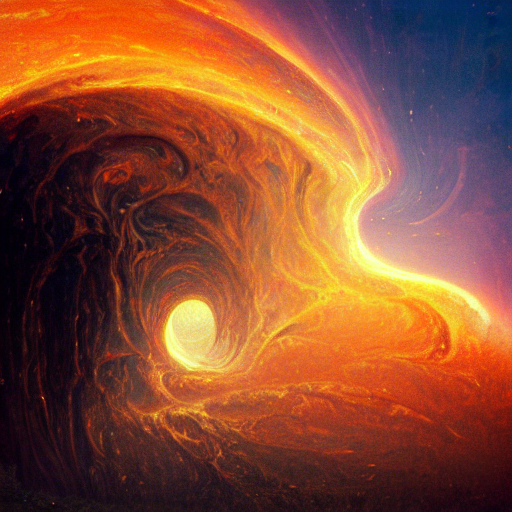

In [7]:
from paint_with_words import paint_with_words

img = paint_with_words(
    color_context={}, # Change here
    color_map_image=None, # Change here
    input_prompt= "<midjourney-style>", # change here
    preloaded_utils=loaded,
)

img